# Porto Seguro Explortory Analysis and Prediction

## Loading Packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv('data/porto_train.csv')
test = pd.read_csv('data/porto_test.csv')

### Quick observations

In [3]:
print(train.shape)
train.head()

(595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
print(test.shape)
test.head()

(892816, 58)


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


### meta data

- use : input, ID, target
- type : nominal, interval, ordinal, binary
- preserve : True or False
- data type : int, float, char
- categort : ind, reg, car, calc

In [5]:
data = []

for feature in train.columns:
    # defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif train[feature].dtype == float or isinstance(train[feature].dtype, float):
        type = 'real'
    else:
        type = 'integer'
    #elif train[feature].dtype == int:
      #  type = 'integer'
        
    preserve  = True
    if feature == 'id':
        preserve = False
                
    dtype = train[feature].dtype
        
    category = 'none'
        
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
          category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
            
    feature_dict = {
        'varname' : feature,
        'use' : use,
        'type' : type,
        'preserve' : preserve,
        'dtype' : dtype,
        'category' : category
    }
    data.append(feature_dict)

metadata = pd.DataFrame(data, columns = ['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace = True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [6]:
metadata[(metadata['type'] == 'categorical') & (metadata['preserve'])].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [7]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()})

# pd.DataFrame(metadata.groupby(['category'])['category'].count())

,count
category,
calculated,20
car,16
individual,18
none,2
registration,3


In [8]:
pd.DataFrame(metadata.groupby(['use', 'type'])['type'].count())

type
use    type             
id     categorical     1
input  binary         17
       categorical    14
       integer        16
       real           10
target binary          1

## Data Analysis and Statistics

<Figure size 432x288 with 0 Axes>

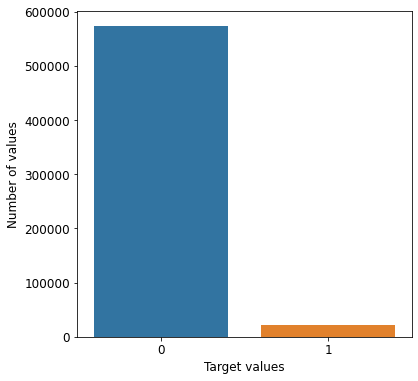

In [9]:
plt.figure()
fig, ax = plt.subplots(figsize = (6,6))

x = train['target'].value_counts().index.values
y = train['target'].value_counts().values

# Bar plot
sns.barplot(ax = ax, x = x, y = y)
plt.ylabel('Number of values', fontsize = 12)
plt.xlabel('Target values', fontsize = 12)
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

### Real features

In [10]:
variable = metadata[(metadata['type'] == 'real') & (metadata['preserve'])].index
train[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


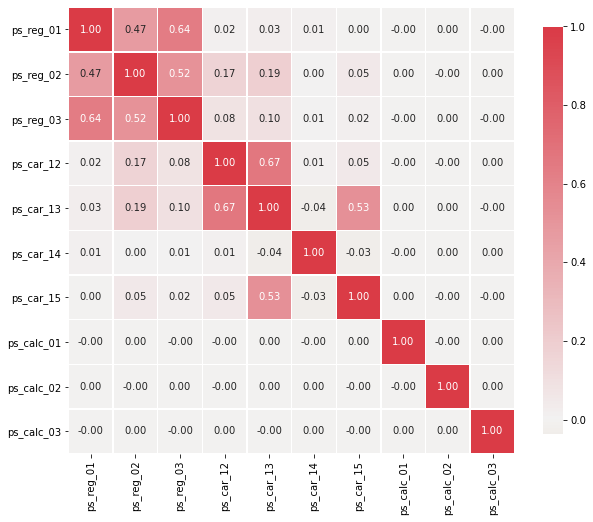

In [11]:
def corr_heatmap(var):
    correlataions = train[var].corr()
    
    cmap = sns.diverging_palette(50, 10, as_cmap = True)
    
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlataions, cmap = cmap, vmax = 1.0, center = 0, fmt = '.2f', square = True, linewidth = .5, annot = True, cbar_kws = {'shrink' : .75})
    plt.show()
    
var = metadata[(metadata['type'] == 'real') & (metadata['preserve'])].index
corr_heatmap(var)

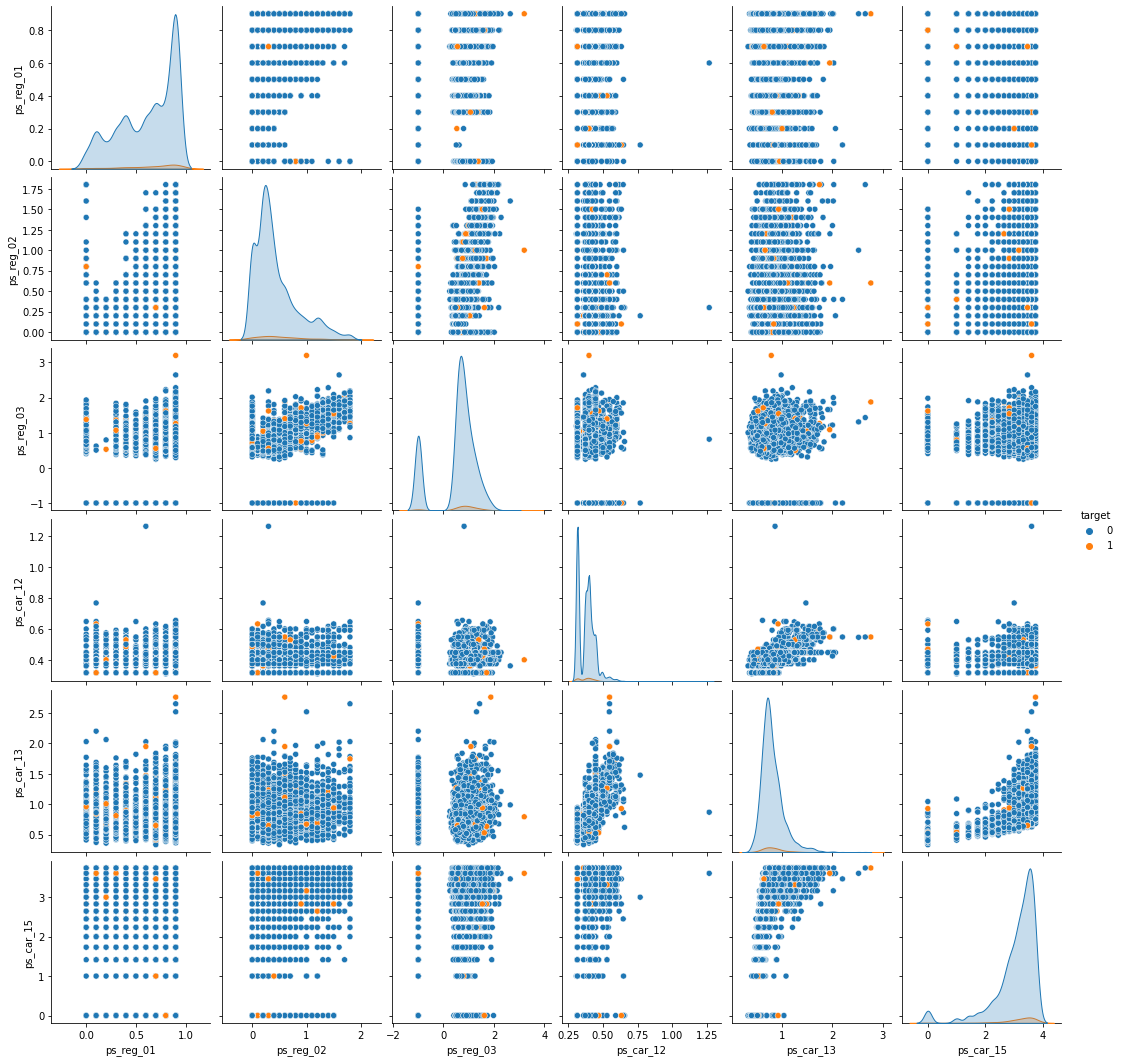

In [12]:
samples = train.sample(frac = 0.01)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',  'ps_car_15', 'target']

sns.pairplot(samples[var], hue = 'target', diag_kind='kde')

## Binary features

In [13]:
v = metadata[(metadata['type'] == 'binary') & (metadata['preserve'])].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Figure size 432x288 with 0 Axes>

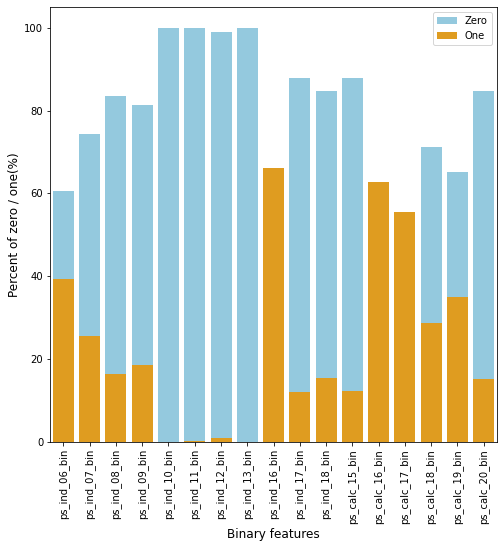

In [14]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []

for col in bin_col:
    zero_list.append((train[col] == 0).sum() / train.shape[0] * 100)
    one_list.append((train[col] == 1).sum() / train.shape[0] * 100)
    
plt.figure()
fig, ax = plt.subplots(figsize = (8,8))

# Bar plot
p1 = sns.barplot(ax = ax, x = bin_col, y = zero_list, color = 'skyblue', label = 'Zero')
p2 = sns.barplot(ax = ax, x = bin_col, y = one_list, color = 'orange', label = 'One')
plt.ylabel('Percent of zero / one(%)', fontsize = 12)
plt.xlabel('Binary features', fontsize = 12)
locs, labels = plt.xticks()
plt.xticks(rotation = 90)
plt.legend()
plt.show()

## Categorical Features

In [15]:
var = metadata[(metadata['type'] == 'categorical') & (metadata['preserve'])].index

def plot_categorical(features):
    for feature in var:
        fig, ax = plt.subplots(figsize = (6,6))
        
        if feature != 'ps_car_11_cat':
            # calculate the percentage of target 1 per category value
            cat_perc = train[[feature,'target']].groupby([feature], as_index = False).mean()
            cat_perc.sort_values('target', ascending = False, inplace = True)
            # Make barplot
            sns.barplot(ax = ax, x = feature, y = 'target', data = cat_perc, order = cat_perc[feature])
            plt.show()
        else:
            cat_perc = train[[feature,'target']].groupby([feature], as_index = False).mean()
            cat_perc = cat_perc.sort_values('target', ascending = False)[:20]
            # Make bar plot
            sns.barplot(ax = ax, x = feature, y = 'target', data = cat_perc, order = cat_perc[feature])
            plt.xticks()
            plt.show()

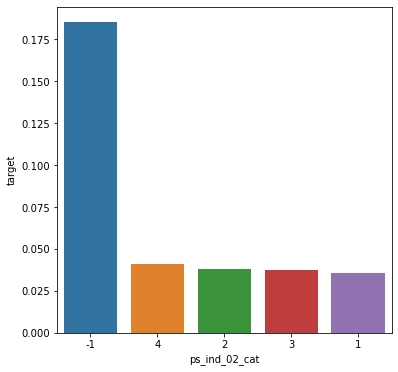

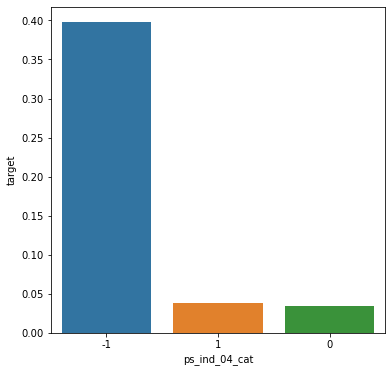

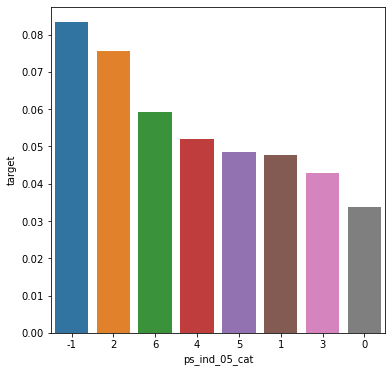

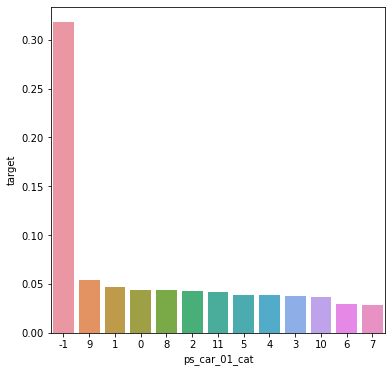

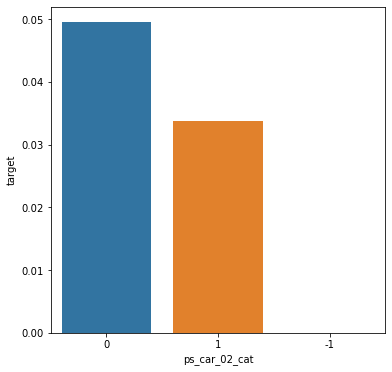

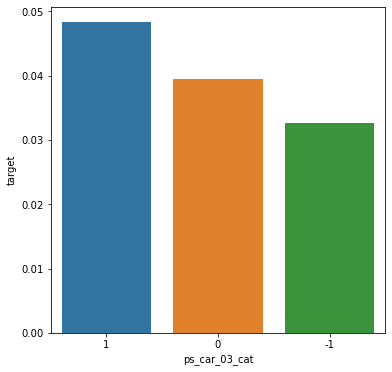

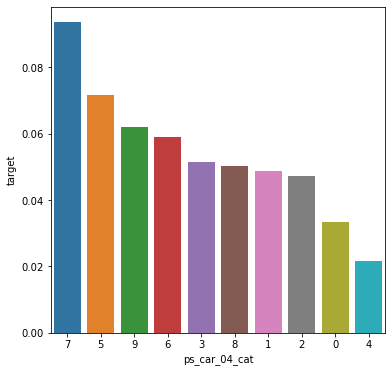

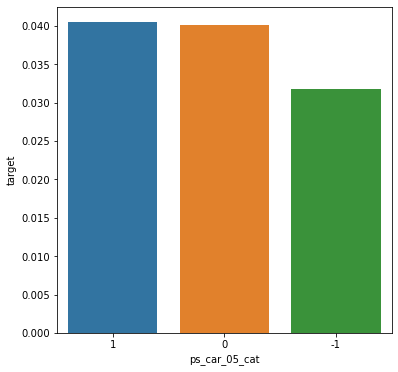

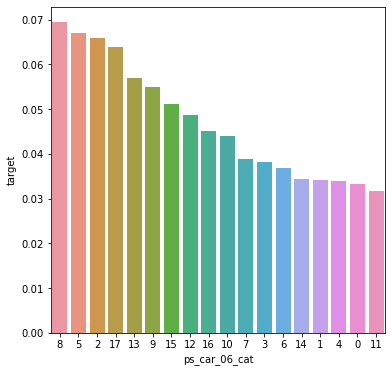

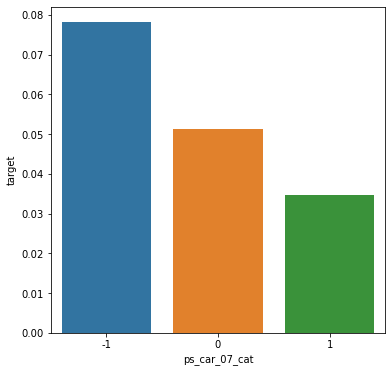

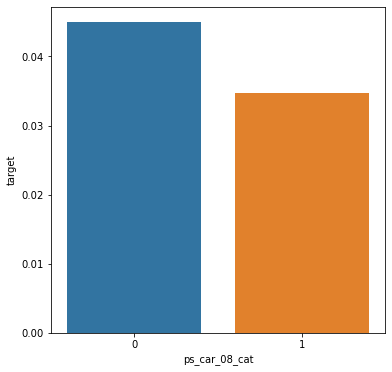

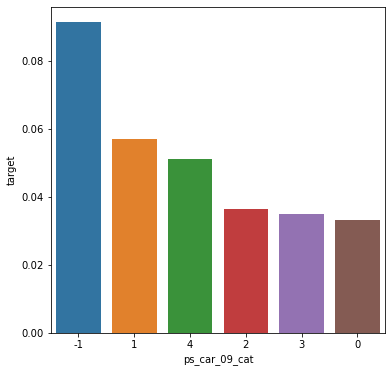

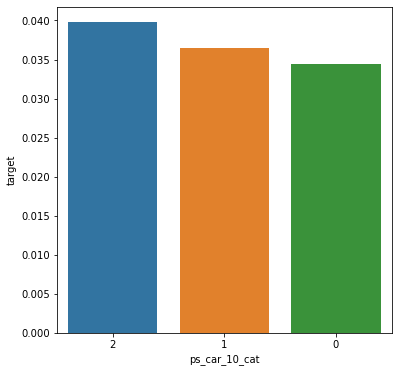

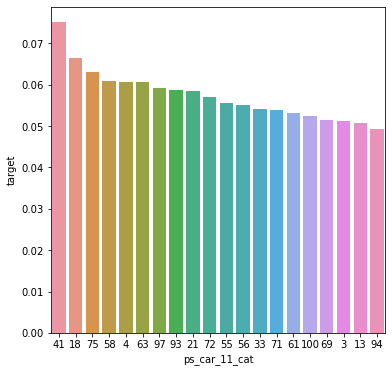

In [16]:
plot_categorical(train[var])

## Check the Data Quality

In [17]:
vars_with_missing = []

for feature in train.columns:
    missings = train[train[feature] == -1][feature].count()
    
    if missings > 0:
        vars_with_missing.append(feature)
        missing_percent = round((missings / train.shape[0])* 100,2)
        
        print('Variable {} has {} missing values and {} %'.format(feature, missings, missing_percent))

Variable ps_ind_02_cat has 216 missing values and 0.04 %
Variable ps_ind_04_cat has 83 missing values and 0.01 %
Variable ps_ind_05_cat has 5809 missing values and 0.98 %
Variable ps_reg_03 has 107772 missing values and 18.11 %
Variable ps_car_01_cat has 107 missing values and 0.02 %
Variable ps_car_02_cat has 5 missing values and 0.0 %
Variable ps_car_03_cat has 411231 missing values and 69.09 %
Variable ps_car_05_cat has 266551 missing values and 44.78 %
Variable ps_car_07_cat has 11489 missing values and 1.93 %
Variable ps_car_09_cat has 569 missing values and 0.1 %
Variable ps_car_11 has 5 missing values and 0.0 %
Variable ps_car_12 has 1 missing values and 0.0 %
Variable ps_car_14 has 42620 missing values and 7.16 %


## Prepare the data for model

### Drop calc columns

In [18]:
col_to_drop = train.columns[train.columns.str.startswith('ps_calc_')]
train = train.drop(col_to_drop, axis = 1)
test = test.drop(col_to_drop, axis = 1)

### Drop variables with too many missing values

In [19]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train = train.drop(vars_to_drop, axis = 1)
test = test.drop(vars_to_drop, axis = 1)
metadata.loc[(vars_to_drop), 'preserve'] = False

In [20]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

### Replace ps_car_11_cat with encoded value

In [21]:
train_encoded , test_encoded = target_encode(train['ps_car_11_cat'],
                                                                                    test['ps_car_11_cat'],
                                                                                    target = train.target,
                                                                                    min_samples_leaf= 100,
                                                                                    smoothing = 10,
                                                                                    noise_level = 0.01)
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis = 1, inplace = True)

test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis = 1, inplace = True)

metadata.loc['ps_car_11_cat', 'preserve'] = False

### Balance target variable

In [22]:
desired_apriori = 0.1

# Get indices target value
idx_0 = train[train['target'] == 0].index
idx_1 = train[train['target'] == 1].index

# Get original number of records per tager value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# calculate the undersampling rate and resulting number of records with target = 0

undersampling_rate = ((1 - desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('Rate to undersample records with target 0: {}'.format(undersampling_rate))
print('Number of records with target 0 after undersampling: {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, n_samples = undersampled_nb_0)

idx_list = list(undersampled_idx) + list(idx_1)

train = train.loc[idx_list].reset_index(drop = True)

Rate to undersample records with target 0: 0.34043569687437886
Number of records with target 0 after undersampling: 195246


### Replace Missing values

In [23]:
train = train.replace(-1, np.nan)
test = test.replace(-1, np.nan)

### Dummify cat values

In [24]:
cat_features = [feature for feature in train.columns if feature.endswith('cat')]

for columns in cat_features:
    temp = pd.get_dummies(pd.Series(train[columns]))
    train = pd.concat([train, temp], axis = 1)
    train = train.drop([columns], axis = 1)
    
for columns in cat_features:
    temp = pd.get_dummies(pd.Series(test[columns]))
    test = pd.concat([test, temp], axis = 1)
    test = test.drop([columns], axis = 1)

### Drop unused and target columns

In [25]:
id_test = test['id'].values
target_train = train['target'].values

train = train.drop(['target', 'id'], axis = 1)
test = test.drop(['id'], axis =1)

In [26]:
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (216940, 91)
Test shape:  (892816, 91)


## Prepare the model

about Class and __init__

https://www.youtube.com/watch?v=xdVt6qbghzI

about enumerate

https://www.youtube.com/watch?v=Y6HTUumwMqA

In [66]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, X, y ,T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        folds = list(StratifiedKFold(n_splits = self.n_splits, shuffle = True, random_state = 314).split(X,y))
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                
                print('Base model %d: fit %s model | fold %d' % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv = 3, scoring = 'roc_auc')
                print('cross_score [roc-auc]: %.5f [gini] :  %.5f' % (cross_score.mean(), 2 * cross_score.mean()-1) )
                y_pred = clf.predict_proba(X_holdout)[:,1]
                
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis =1)
            
        results = cross_val_score(self.stacker, S_train, y, cv = 3, scoring = 'roc_auc')
        
        print('Stacker score [gini] : %.5f' % (2 * results.mean() - 1 ))
        
        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

### Parameters for the base models

In [72]:
# LightGBM params

lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 120
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02
lgb_params2['n_estimators'] = 150
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['colsample_bytree'] = 0.3
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4
lgb_params2['num_leaves'] = 16

lgb_params3 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 170
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4
lgb_params3['max_depth'] = 4

xgb_params = {}
# xgb_params['objective'] = "binary : logistic"
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 100
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

### Initailize the models with the parameters

In [73]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)

lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model

log_model = LogisticRegression()

### Initialize the ensambling object

In [74]:
stack = Ensemble(n_splits = 3, stacker=log_model, base_models=(lgb_model1, lgb_model2, lgb_model3, xgb_model))

## Run the predictive models

In [75]:
y_prediction = stack.fit_predict(train, target_train, test)

Base model 1: fit LGBMClassifier model | fold 1
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63859 [gini] :  0.27718
Base model 1: fit LGBMClassifier model | fold 2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63684 [gini] :  0.27369
Base model 1: fit LGBMClassifier model | fold 3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be igno